In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pandas as pd
import _pickle as cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

/home/kacper/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kacper/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/kacper/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20

In [2]:
data = pd.read_csv("data/L7/breast_cancer_transformer.csv")
data.drop("Unnamed: 32",axis=1,inplace=True)
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})

In [3]:
# Wybieramy cechy
prediction_var = ['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean']
train, test = train_test_split(data, test_size = 0.3)# in this our main data is splitted into train and test
train_X = train[prediction_var][0:100]
train_y=train.diagnosis[0:100]
test_X= test[prediction_var] 
test_y =test.diagnosis  

In [4]:
# Regresja logistyczna
model = LogisticRegression(C=50)
model.fit(train_X,train_y)
pred = model.predict(test_X)
print( metrics.accuracy_score(pred, test_y))
print (metrics.precision_score(pred, test_y))
print (metrics.recall_score(pred, test_y))
print (metrics.log_loss(test_y, model.predict_proba(test_X)[:, 1]))

0.912280701754
0.828571428571
0.950819672131
0.195457234021


## Zadanie 1 [3 pkt]

1. Powyższy model ma istotnie wyższy recall niż precision. 

Zdefiniujmy jako model probabilistyczny model, który zwraca p($\hat{y}$ | y). Obiekt LogisticRegression zwraca tą wartość funkcją ``predict_proba``

1. Każdy model probabilistyczny można użyć do stworzenia klasyfikora, która może mieć precision 100% lub recall 100% trywialnie, jak? 

2. Krzywa precision/recall jest obliczana licząc precision oraz recall modelu probabilistycznego dla różnych wartości precision. Zarysuj wykres precision/recall dla modelu powyżej.

Powinno wyjść:

<img src="figures/L7/prec_recall.png">

1. Precision 100% można uzyskać poprzez model, który zawsze klasyfikuje obiekt jako fałsz. Podobnie Recall 100% dostajemy klasyfikując zawsze jako prawda.

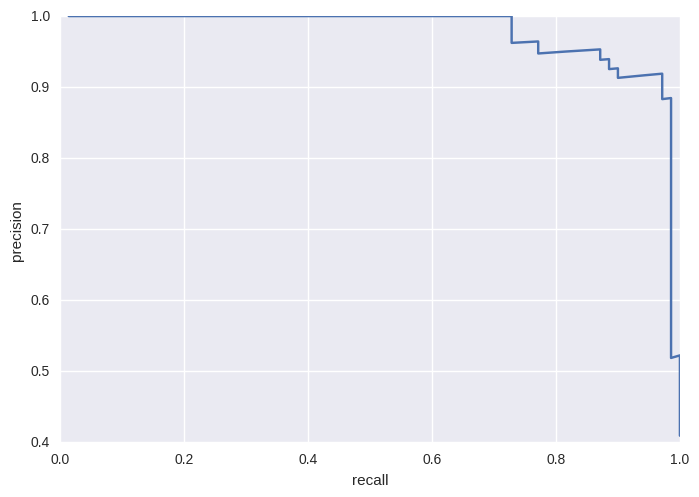

In [5]:
probs = model.predict_proba(test_X).T[0]
indices = np.argsort(probs)
ordered_classes = [test_y.values[i] for i in indices]
ordered_classes_cumsum = np.cumsum(ordered_classes)
prec = [ordered_classes_cumsum[i]/(i+1) for i in range(len(test_X))]
recall = [ordered_classes_cumsum[i]/ordered_classes_cumsum[-1] for i in range(len(test_X))]

    
plt.plot(recall, prec)
plt.xlabel('recall')
plt.ylabel('precision')


## Zadanie 2 [3 pkt]

Założmy, że $C_{FP}$ = 1 i $C_{FN}$ = 10, co odpowiada sytuacji w której nie przejmujemy się postawieniem fałszywej pozytywnej diagnozy.

Według http://web.cs.iastate.edu/~honavar/elkan.pdf wystarczy w takim wypadku dodać przykładom odpowiednią wage.

a) Przetestuj pare wag klasy negatywnej przez podanie argumentu class_weight do LogisticRegression. Dla każdej wartości wagi narysuj dokładność (accuracy) oraz wynik metryki FN_aversive. Powinno wyjść:

<img src="figures/L7/fn_aversive.png">

b) Równoważnym sposobem tworzenia "cost-sensitive" klasyfikatora z modelu probabilistycznego jest zmiana progu (patrz Zadanie 1). Znajdź taki próg, aby wynik klasyfikatora z tym progiem był równoważny argumentowi class_weight, który daje w punkcie a) najlepszy wynik.

Podpowiedź: Jeśli 2 sprawia problem, przejrzyj załączoną publikację

In [6]:
def FN_aversive(y_true, y_pred):
    FN = sum((y_true == 1) * (y_pred != y_true))
    FP = sum((y_true == 0) * (y_pred != y_true))
    return 10 * FN + FP

/home/kacper/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


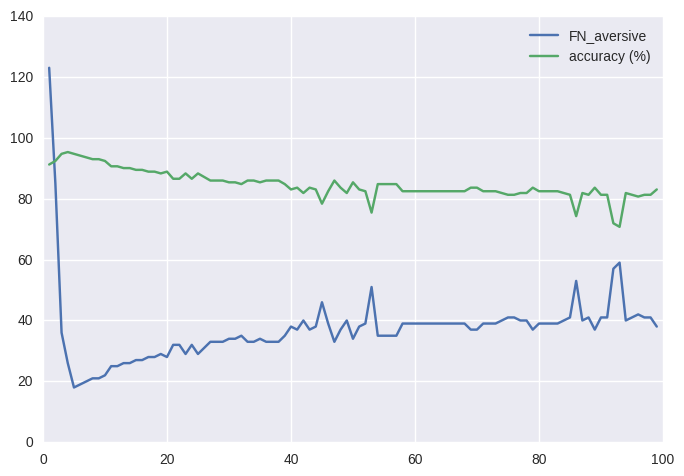

In [7]:
acc = []
fn = []

for i in range(1,100):
    model = LogisticRegression(C = 50, class_weight = {0: 1, 1: i})
    model.fit(train_X,train_y)
    pred = model.predict(test_X)
    acc.append(metrics.accuracy_score(pred, test_y)*100)
    fn.append(FN_aversive(test_y, pred))


plt.plot(range(1,100), fn, label= "FN_aversive")
plt.plot(range(1,100), acc, label= "accuracy (%)")
plt.legend()

In [8]:
s_acc = acc[np.argmin(fn)]/100

index = 0
dist = 1
for i, acc_element in enumerate(prec):
    if abs(acc_element-s_acc) < dist:
        dist = acc_element-s_acc
        index = i

prog = np.sort(probs)[index]
print("znaleziony prog wynosi: {0}".format(prog))

znaleziony prog wynosi: 0.4000761621012321


## Zadanie 3 [3 pkt]

Naive Bayes jest często stosowany do problemów klasyfikacyjnych na tekście. W tym zadaniu zajmiemy się klasyfikacją SPAMU. Na wejściu zadany jest test wiadomości e-mail, etykietą jest 0 (prawdziwa wiadomość, "HAM") lub 1 (SPAM). 

Podstawowym problemem jest sposób reprezentacji tekstu. Podobnie jak w przypadku rozważanych funkcji bazowych na wcześniejszych zajęciach, modele wymagają stałowymiarowego wektoru. Proszę użyć klasy CountVectorizer z sklearn w celu przekształcenia wiadomości do reprezentacji wektorowej.

1. Zastosuj transformację tekstu do reprezentacji bag of words
2. Naucz model Naive Bayes (MultinomialNB) przewidywać SPAM
3. Pokaż problem "double counting" w modelu Naive Bayes. 

### Załadowanie danych

In [9]:
messages = pd.read_csv('data/L7/smsspamcollection/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

In [10]:
messages['length'] = messages['message'].map(lambda text: len(text))

## Przetworzenie danych

In [11]:
messages_bow = np.mat(CountVectorizer().fit_transform(messages['message']).toarray())
print ('sparse matrix shape:', messages_bow.shape)
print ('number of non-zeros:', len(messages_bow.nonzero()[0]))
print ('sparsity: %.2f%%' % (100.0 * len(messages_bow.nonzero()[0]) / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8713)
number of non-zeros: 74169
sparsity: 0.15%


In [12]:
data = [[np.array(messages_bow[i])[0], messages['label'][i]] for i in range(len(messages))]

In [13]:
train, test = train_test_split(data, test_size = 0.3)# in this our main data is splitted into train and test
train_X = list(np.transpose(train)[0])
train_y = list(np.transpose(train)[1])
test_X = list(np.transpose(test)[0])
test_y = list(np.transpose(test)[1])

In [14]:
spam_detector = MultinomialNB()
spam_detector.fit(list(train_X), train_y)

pred = spam_detector.predict(test_X)

In [15]:
TP = sum(pred[i] == test_y[i] == 'spam' for i in range(len(pred)))
FP = sum((pred[i] != test_y[i] and pred[i] == 'spam') for i in range(len(pred)))
TN = sum(pred[i] == test_y[i] == 'ham' for i in range(len(pred)))
FN = sum((pred[i] != test_y[i] and pred[i] == 'ham') for i in range(len(pred)))

In [16]:

print( 'accuracy: {0}'.format(metrics.accuracy_score(pred, test_y)))
print('\n\nconfusion matrix:\n')
print("TP: {0}".format(TP))
print("FP: {0}".format(FP))
print("TN: {0}".format(TN))
print("FN: {0}".format(FN))

accuracy: 0.9856545128511656


confusion matrix:

TP: 198
FP: 11
TN: 1451
FN: 13


c) Niech dany będzie problem klasyfikacji z dwoma klasami $(T,F)$ na podstawie dwóch niezależnych binarnych cech $X_{1}, X_{2}$.
Niech będzie teraz dane, że:

$P(Y=T) = 0.5$

$P(X_{1} = T | Y=T) = 0.8$

$P(X_{1} = F | Y=F) = 0.7$

$P(X_{2} = T | Y=T) = 0.5$

$P(X_{2} = F | Y=F) = 0.9$

Model Naive Bayes będzie przypisywał parę $(x_{1},x_{2})$ do klasy $T$ jeśli będzie zachodzić: 

$$ \log  \dfrac{P(Y=T)}{P(Y=F)} + \log \dfrac{P(X_{1} = x_{1} | Y=T)}{P(X_{1} = x_{1} | Y=F)} + \log \dfrac{P(X_{2} = x_{2} | Y=T)}{P(X_{2} = x_{2} | Y=F)} > 0$$

W przeciwnym wypadku model sklasyfikuje obiekt jako F.








In [17]:
#(T,T)
print(np.log(0.8/0.3) + np.log(0.5/0.1))
##(T,F)
print(np.log(0.8/0.3) + np.log(0.5/0.9))
##(F,T)
print(np.log(0.2/0.7) + np.log(0.5/0.1))
##(F,F)
print(np.log(0.2/0.7) + np.log(0.5/0.9))

2.59026716545
0.39304258811
0.356674943939
-1.8405496334


Łatwo więc policzyć (powyżej), że będziemy mieli następujące predykcje: 

$ \hat{Y}(T,T) = T$

$ \hat{Y}(T,F) = T$

$ \hat{Y}(F,T) = T$

$ \hat{Y}(F,F) = F$

Policzmy więc jak często średnio nasz model się myli. Pamiętając, że z niezależności $X_{1}$ i $X_{2}$ mamy: $$P(X_{1},X_{2},Y) = P(X_{1}|Y) \cdot P(X_{2}|Y) \cdot P(Y),$$
będzie to więc:
$$Err_{rate} = P(X_{1} = T, X_{2} = T, Y=F) + P(X_{1} = T, X_{2} = F, Y=F) + P(X_{1} = F, X_{2} = T, Y=F) + P(X_{1} = F, X_{2} = F, Y=T) = \\ = 0.5 \cdot 0.3 \cdot 0.1 + 0.5 \cdot 0.3 \cdot 0.9 + 0.5 \cdot 0.7 \cdot 0.1 + 0.5 \cdot 0.2 \cdot 0.5 = 0.235$$


Dołóżmy teraz trzecią cechę $X_{3}$ będącą kopią cechy $X_{2}$ - są one więc w pełni zależne od siebie. Model Naive Bayes jednak tego nie widzi, stąd decyzję o klasyfikacji będzie podejmował na podstawie warunku:

$$ \log  \dfrac{P(Y=T)}{P(Y=F)} + \log \dfrac{P(X_{1} = x_{1} | Y=T)}{P(X_{1} = x_{1} | Y=F)} + \log \dfrac{P(X_{2} = x_{2} | Y=T)}{P(X_{2} = x_{2} | Y=F)} + \log \dfrac{P(X_{3} = x_{3} | Y=T)}{P(X_{3} = x_{3} | Y=F)} > 0$$



In [18]:
#(T,T)
print(np.log(0.8/0.3) + np.log(0.5/0.1) + np.log(0.5/0.1))
##(T,F)
print(np.log(0.8/0.3) + np.log(0.5/0.9)+ np.log(0.5/0.9))
##(F,T)
print(np.log(0.2/0.7) + np.log(0.5/0.1) + np.log(0.5/0.1))
##(F,F)
print(np.log(0.2/0.7) + np.log(0.5/0.9) + np.log(0.5/0.9))

4.19970507788
-0.194744076793
1.96611285637
-2.4283362983


W konsekwencji predykcje ulegną zmianie na (powyżej, zmienna $X_{3}$ została pominięta w zapisie, jest równa $X_{2})$:

$ \hat{Y}(T,T) = T$

$ \hat{Y}(T,F) = F$

$ \hat{Y}(F,T) = T$

$ \hat{Y}(F,F) = F$

Po uaktalnieniu policzmy ponownie częstość popełniania błędu przez nasz model:

$$Err_{rate} = P(X_{1} = T, X_{2} = T, Y=F) + P(X_{1} = T, X_{2} = F, Y=T) + P(X_{1} = F, X_{2} = T, Y=F) + P(X_{1} = F, X_{2} = F, Y=T) = \\ = 0.5 \cdot 0.3 \cdot 0.1 + 0.5 \cdot 0.8 \cdot 0.5 + 0.5 \cdot 0.7 \cdot 0.1 + 0.5 \cdot 0.2 \cdot 0.5 = 0.3$$

Czyli mylimy się częściej. 

Zaprezentowałem problem "Double Counting" w pewnym sensie w odwrotnym kierunku. W rzeczywistości chodzi o to, że gdybyśmy zaczęli od drugiej sytuacji i zauważyli, że zmienne $X_{2}$ i $X_{3}$ są skorelowane, moglibyśmy zmniejszyć częstotliwość popełnienia błędu.